In [1]:
import torch

c:\Users\casey\Work\SmartCarteContainers\notebooks\venvnn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x = torch.rand(2, 2)
y = torch.rand(2, 2)

z = x.mul(y)

val = z[0, 1]
print(val)
print(val.item())

tensor(0.0009)
0.0008645428461022675


In [3]:
# reshaping
view = x.view(4, 1)
print(view)

tensor([[0.5774],
        [0.0023],
        [0.8425],
        [0.6044]])


In [4]:
import numpy as np

# change one will change the other if both on CPU (not GPU)

a = torch.rand(5)
print(a)

b = a.numpy()
print(b)

a.add_(1)
print(a)
print(b)

tensor([0.4337, 0.7251, 0.6140, 0.8373, 0.4396])
[0.43366426 0.7251383  0.6139728  0.83731425 0.43959004]
tensor([1.4337, 1.7251, 1.6140, 1.8373, 1.4396])
[1.4336643 1.7251383 1.6139728 1.8373142 1.43959  ]


In [3]:
# check if you have a GPU available
# this isn't possible with Windows and ROCm (only Linux)
if torch.cuda.is_available():
    print("hey")
    device = torch.device("cuda")
    x = torch.ones(5, device=device)
    y = torch.rand(5)
    y = y.to(device)
    z = x + y
    # z.numpy() ...causes an error
    z = z.to("cpu")
    z.numpy()

In [ ]:
# autograd

x = torch.rand(3, requires_grad=True)
print(x)

y = x + 2 # <AddBackward>
print(y)

z = y * y * 2 # <MulBackward>
print(z)

z = z.mean() # <MeanBackward>
print(z)
# v = torch.tensor([0.1, 1.0, 0.001], dtype=torch.float32)

z.backward() # can only be created for scalar inputs (i.e. one value), otherwise pass v to backward
print(x.grad)

tensor([0.0532, 0.4881, 0.3649], requires_grad=True)
tensor([2.0532, 2.4881, 2.3649], grad_fn=<AddBackward0>)
tensor([ 8.4309, 12.3811, 11.1856], grad_fn=<MulBackward0>)
tensor(10.6659, grad_fn=<MeanBackward0>)
tensor([2.7375, 3.3174, 3.1532])


In [4]:
# PyTorch Lightning

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pytorch_lightning as pl


# hyperparameters

input_size = 784 # 28x28 I think the input size must be the same! Bboxes must be same size.
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001


class NeuralNet(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        # self.l0 = nn.Conv3d(4, 4, 10) can do cool stuff like this
        self.l1 = nn.Linear(input_size, hidden_size) # weights are randomly initialized
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.reshape(-1, 28*28)
        
        # forward pass
        outputs = self.forward(images)
        # outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        
        tensorboard_logs = {'train_loss': loss}
        
        return {'loss': loss, 'log': tensorboard_logs}

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

    
    def train_dataloader(self):
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=batch_size, 
                                                   num_workers=4,
                                                   shuffle=True)
        return train_loader

    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.reshape(-1, 28*28)
        
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return {'val_loss': loss}


    def val_dataloader(self):
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                   batch_size=batch_size, 
                                                   num_workers=4,
                                                   shuffle=False)
        return test_loader
    

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        
        tensorboard_logs = {'avg_val_loss': avg_loss}
        
        return {'val_loss': avg_loss, 'log': tensorboard_logs}


trainer = pl.Trainer(fast_dev_run=False, max_epochs=num_epochs) # gpus=1, auto_lr_find=True
model = NeuralNet(input_size, hidden_size, num_classes)
lr_find_result = trainer.tuner.lr_find(model, 
                                       early_stop_threshold=None,
                                       train_dataloaders=model.train_dataloader(), 
                                       val_dataloaders=model.val_dataloader())
new_lr = lr_find_result.suggestion()
print('new_lr: ', new_lr)
model.learning_rate = new_lr
trainer.fit(model, train_dataloaders=model.train_dataloader(), val_dataloaders=model.val_dataloader())


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 54.22it/s]
Restoring states from the checkpoint path at c:\Users\casey\Work\SmartCarteContainers\notebooks\src\.lr_find_748e9133-09a8-4809-97f0-66d02d6411fd.ckpt
Restored all states from the checkpoint file at c:\Users\casey\Work\SmartCarteContainers\notebooks\src\.lr_find_748e9133-09a8-4809-97f0-66d02d6411fd.ckpt


new_lr:  0.003981071705534969


## Semantic Segmentation with PyTorch

In [72]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision


from common.constants import NODATA_FLOAT32


torch.manual_seed(666)


class LabeledS2Dataset(Dataset):
    def __init__(self, root_dir, sub_dir):
        self.data_dir = f'{root_dir}/{sub_dir}'
        self.image_paths = glob.glob(f'{self.data_dir}/images/*.tif')
        self.label_paths = glob.glob(f'{self.data_dir}/labels/*.tif')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]

        with rasterio.open(image_path) as src:
            image = src.read()
            image[image == NODATA_FLOAT32] = -0.01
            # handle nodata here...
            image = torch.from_numpy(image)

        with rasterio.open(label_path) as src:
            label = src.read() # .read(1)
            # NOT WORKING... label[label == 0] = np.nan
            #label = np.expand_dims(label, 0)
            label = torch.from_numpy(label).long()

        return image, label    
    

train_dataset = LabeledS2Dataset(root_dir='./data/trainingData', sub_dir='train')
train_dataloader = DataLoader(train_dataset, batch_size=2, num_workers=0, shuffle=True)

test_dataset = LabeledS2Dataset(root_dir='./data/trainingData', sub_dir='test')
test_dataloader = DataLoader(test_dataset, batch_size=2, num_workers=0, shuffle=True)

val_dataset = LabeledS2Dataset(root_dir='./data/trainingData', sub_dir='val')
val_dataloader = DataLoader(val_dataset, batch_size=2, num_workers=0, shuffle=True)


In [73]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
import torch.optim as optim


CLASSES = {
    'unclassified': 0,
    'agriculture': 1,
    'bare_dark': 2,
    'bare_light': 3,
    'built': 4,
    'burn': 5,
    'cloud': 6,
    'flooded_vegetation': 7,
    'grass_dry': 8,
    'grass_verdant': 9,
    'shrubs': 10,
    'trees': 11,
    'water': 12,   
}

CLASS_NAMES = list(CLASSES.keys())
CLASS_INDEXES = list(CLASSES.values())
DEVICE = 'cuda'

model = smp.UnetPlusPlus(
    encoder_name='resnet18', 
    encoder_depth=5, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16), 
    decoder_attention_type=None, 
    in_channels=4, 
    classes=len(CLASS_NAMES), 
    activation=None, 
    aux_params=None
)


loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = 'Dice_loss'

optimizer = optim.Adam(params=model.parameters(), lr=0.001)

metrics = []


In [74]:

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    verbose=True,
)

test_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    verbose=True,
)


In [75]:
max_score = 0

for i in range(0, 1):
    train_logs = train_epoch.run(train_dataloader)
    test_logs = test_epoch.run(test_dataloader)
    torch.save(model, './best_model.pth')
    
print('done')

valid: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, Dice_loss - 0.1864]
done


In [76]:

best_model = torch.load('./best_model.pth')

val_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics
)

logs = val_epoch.run(val_dataloader)
print(logs)

valid: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s, Dice_loss - 0.2402]
{'Dice_loss': 0.24023571362098056}


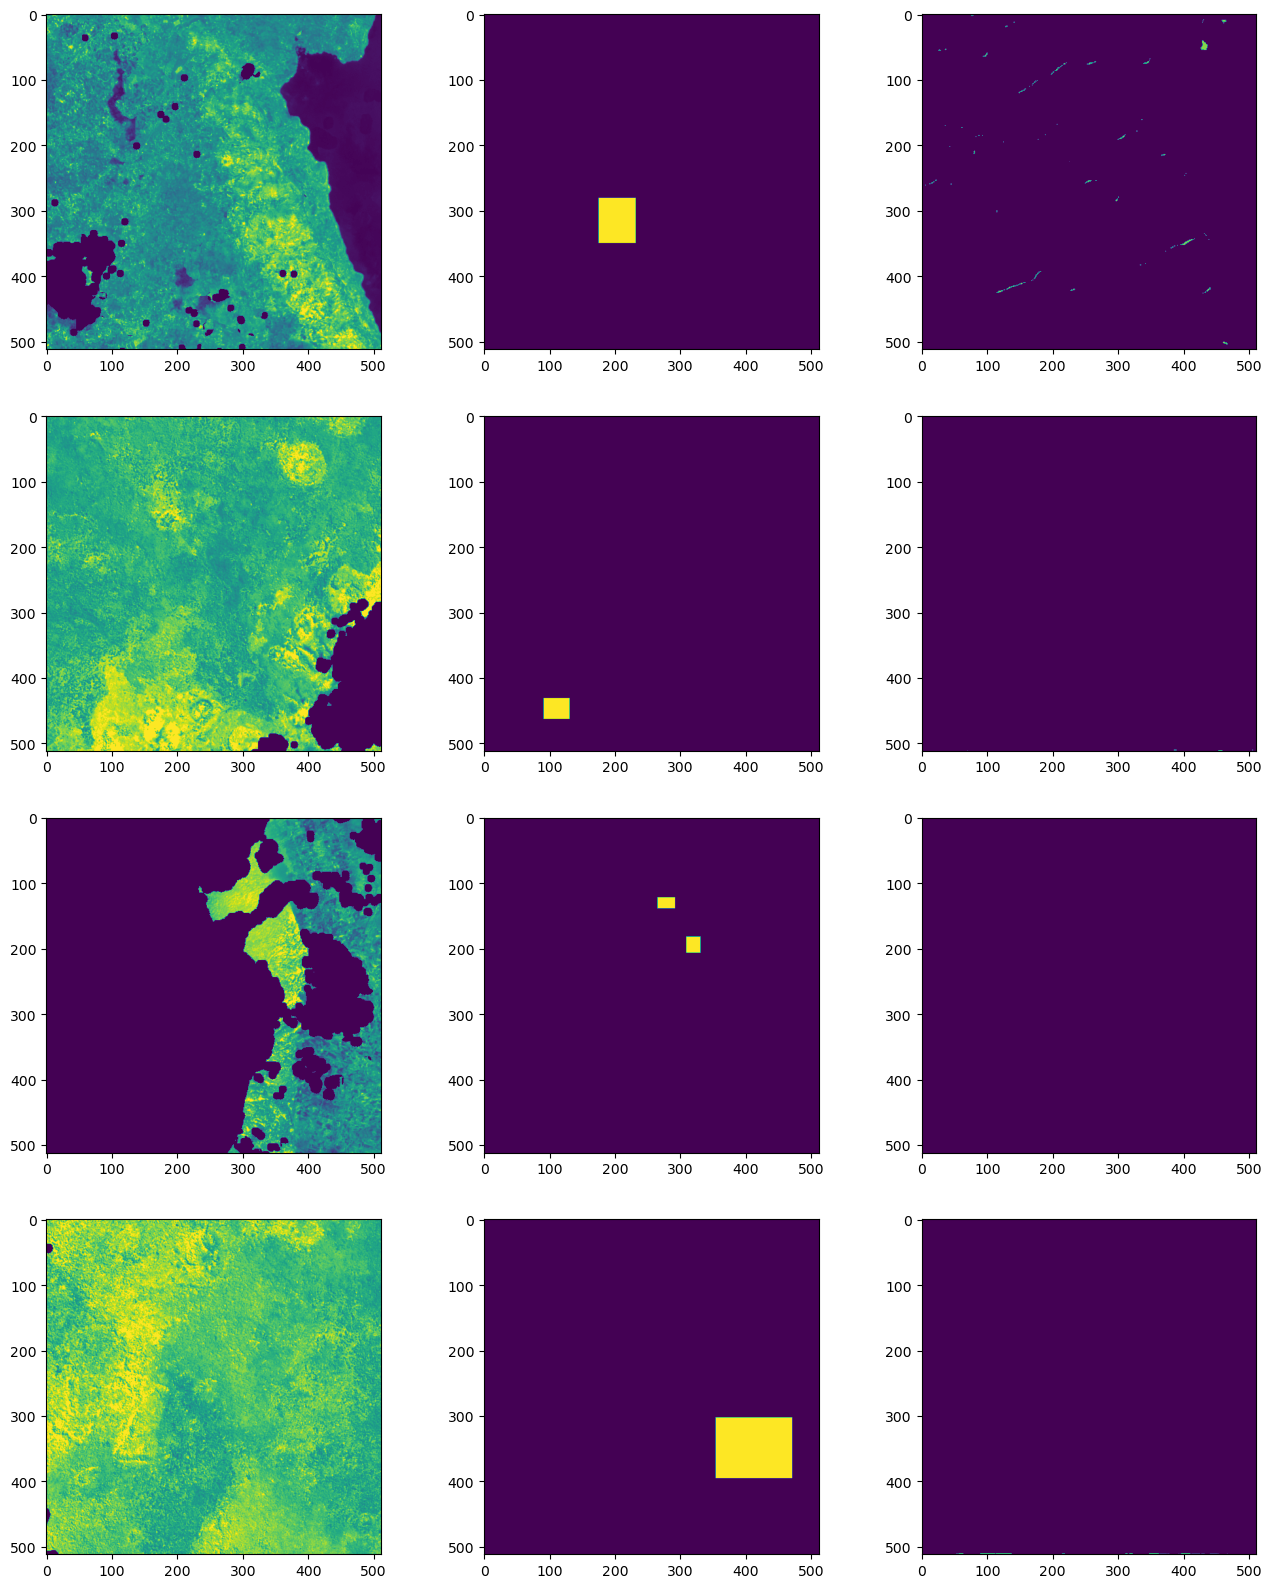

In [77]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


count = 4

fig, rows = plt.subplots(count, 3, figsize=(16, 20))
    

for i in range(count):
        
    image, labels = val_dataset[i]   
    image = np.expand_dims(image, 0)
    image = torch.tensor(image)

    prediction = best_model.predict(image)
    
    softmax = nn.Softmax(dim=1)
    probabilities = softmax(prediction)
    
    prediction = torch.argmax(probabilities, dim=1).squeeze(1)
    prediction = (prediction.squeeze().cpu().numpy().round())
    
    
    row = rows[i]
    
    row[0].imshow(image.squeeze()[3])
    row[1].imshow(labels.squeeze())
    row[2].imshow(prediction)
    

    